# Batch calibration & simulation

First create artificial returns from simple surrogate order-flow and the HDIM2 model. Then try to recover the kernels again and to predict the return using several different models.
You might need to `pip install matplotlib colorednoise` if you didn't install all of these optional packages yet.

In [1]:
import os

# set the backend
import matplotlib.pyplot as plt


# standard packages
import numpy as np
import pandas as pd

# included noise generator
from colorednoise import powerlaw_psd_gaussian

# propagator models
import priceprop as prop
import priceprop.batch as pb
import scorr

In [2]:
%load_ext autoreload
%autoreload 2

### Load real orderflow

In [3]:
stock = "AAPL"
current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')
filename = f"{stock}-2017-NEW.csv"
stock_file_path = os.path.join(data_dir, filename)
aapl_raw_df = pd.read_csv(stock_file_path)

In [4]:
aapl_raw_df.head()

,Unnamed: 0,event_timestamp,sign,side,lob_action,order_executed,execution_price,size,ask,bid,...,average_vol_at_best,midprice_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,0,2017-01-03 10:30:00.544161131,1,ASK,REMOVE,True,115.70,100,115.70,115.69,...,1045.040418,0.00,0.00,0.01,2017-01-03,0.004271,1398089,6170,0.095690,100
1,1,2017-01-03 10:30:02.758712611,-1,BID,REMOVE,True,115.69,153,115.70,115.69,...,762.184840,-0.01,0.01,0.01,2017-01-03,0.004271,1398089,6170,0.200739,-153
2,2,2017-01-03 10:30:02.852790059,1,ASK,REMOVE,True,115.69,200,115.69,115.68,...,1045.040418,0.01,0.01,0.01,2017-01-03,0.004271,1398089,6170,0.191380,200
3,3,2017-01-03 10:30:04.539218241,1,ASK,REMOVE,True,115.70,100,115.70,115.69,...,1045.040418,0.00,0.00,0.01,2017-01-03,0.004271,1398089,6170,0.095690,100
4,4,2017-01-03 10:30:07.865732286,1,ASK,UPDATE,True,115.70,10,115.70,115.69,...,1045.040418,0.00,0.00,0.01,2017-01-03,0.004271,1398089,6170,0.009569,10


In [5]:
aapl_raw_df.columns

Index(['Unnamed: 0', 'event_timestamp', 'sign', 'side', 'lob_action',
       'order_executed', 'execution_price', 'size', 'ask', 'bid', 'midprice',
       'ask_volume', 'bid_volume', 'price_changing', 'ask_queue_size_mean',
       'bid_queue_size_mean', 'average_num_at_best', 'average_vol_at_best',
       'midprice_change', 'R1', 'spread', 'date', 'daily_R1', 'daily_vol',
       'daily_num', 'norm_size', 'signed_volume'],
      dtype='object')

In [6]:
aapl_data = aapl_raw_df[["event_timestamp", "R1", "sign", "price_changing"]]

In [7]:
aapl_data.head()

,event_timestamp,R1,sign,price_changing
0,2017-01-03 10:30:00.544161131,0.00,1,True
1,2017-01-03 10:30:02.758712611,0.01,-1,True
2,2017-01-03 10:30:02.852790059,0.01,1,True
3,2017-01-03 10:30:04.539218241,0.00,1,True
4,2017-01-03 10:30:07.865732286,0.00,1,False


In [8]:
aapl_data.shape

(2633978, 4)

In [9]:
from liquidity.features import compute_aggregate_features

appl_data_clean = compute_aggregate_features(aapl_raw_df, [1])

In [10]:
appl_data_clean.shape

(2633727, 15)

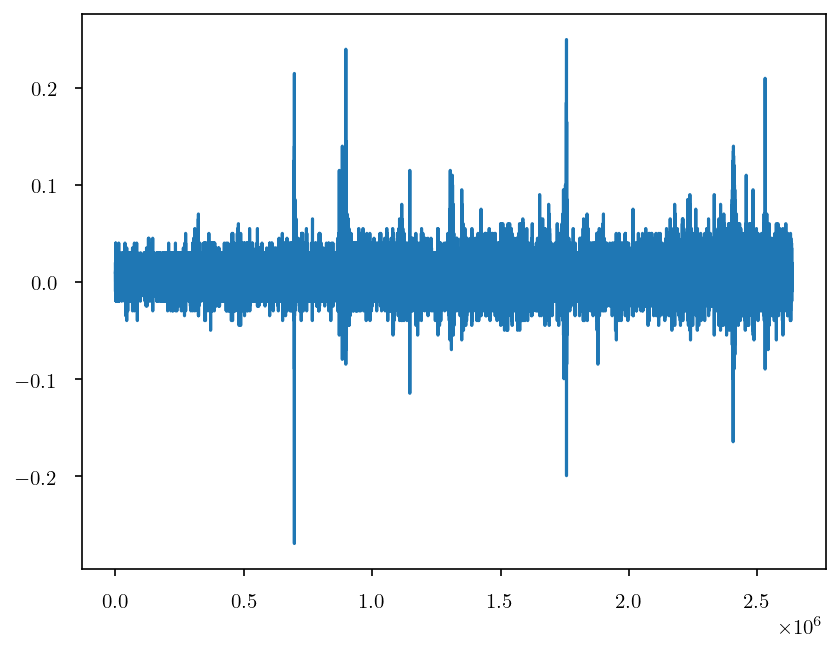

In [11]:
plt.plot(appl_data_clean["R1"])

In [12]:
appl_data_clean

,event_timestamp,R1,midprice,sign,signed_volume,price_changing,daily_R1,daily_num,daily_vol,volume_imbalance,sign_imbalance,price_change_imbalance,average_num_at_best,average_vol_at_best,T
0,2017-01-03 10:30:02.758712611,0.010,115.695,-1,-153,True,0.004271,6170,1398089,-153,-1,1,6.032068,762.184840,1
1,2017-01-03 10:30:02.852790059,0.010,115.685,1,200,True,0.004271,6170,1398089,200,1,1,7.283424,1045.040418,1
2,2017-01-03 10:30:04.539218241,0.000,115.695,1,100,True,0.004271,6170,1398089,100,1,1,7.283424,1045.040418,1
3,2017-01-03 10:30:07.865732286,0.000,115.695,1,10,False,0.004271,6170,1398089,10,1,0,7.283424,1045.040418,1
4,2017-01-03 10:30:08.360855091,0.000,115.695,1,300,False,0.004271,6170,1398089,300,1,0,7.283424,1045.040418,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633722,2017-12-29 14:59:22.595997049,0.005,169.985,1,200,True,0.030568,6735,1452499,200,1,1,3.711482,773.098946,1
2633723,2017-12-29 14:59:26.825179397,0.005,169.990,1,1200,True,0.030568,6735,1452499,1200,1,1,3.711482,773.098946,1
2633724,2017-12-29 14:59:58.621436793,0.000,169.995,-1,-300,False,0.030568,6735,1452499,-300,-1,0,3.890007,725.867637,1
2633725,2017-12-29 14:59:58.621758027,0.010,169.995,-1,-205,True,0.030568,6735,1452499,-205,-1,1,3.890007,725.867637,1


In [13]:
from market_impact.util.data_utils import normalize_impact

In [14]:
appl_data_clean = normalize_impact(appl_data_clean, "R1")

In [15]:
appl_data_clean

,event_timestamp,R1,midprice,sign,signed_volume,price_changing,daily_R1,daily_num,daily_vol,volume_imbalance,sign_imbalance,price_change_imbalance,average_num_at_best,average_vol_at_best,T
0,2017-01-03 10:30:02.758712611,2.341556,115.695,-1,-153,True,0.004271,6170,1398089,-153,-1,1,6.032068,762.184840,1
1,2017-01-03 10:30:02.852790059,2.341556,115.685,1,200,True,0.004271,6170,1398089,200,1,1,7.283424,1045.040418,1
2,2017-01-03 10:30:04.539218241,0.000000,115.695,1,100,True,0.004271,6170,1398089,100,1,1,7.283424,1045.040418,1
3,2017-01-03 10:30:07.865732286,0.000000,115.695,1,10,False,0.004271,6170,1398089,10,1,0,7.283424,1045.040418,1
4,2017-01-03 10:30:08.360855091,0.000000,115.695,1,300,False,0.004271,6170,1398089,300,1,0,7.283424,1045.040418,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633722,2017-12-29 14:59:22.595997049,0.163570,169.985,1,200,True,0.030568,6735,1452499,200,1,1,3.711482,773.098946,1
2633723,2017-12-29 14:59:26.825179397,0.163570,169.990,1,1200,True,0.030568,6735,1452499,1200,1,1,3.711482,773.098946,1
2633724,2017-12-29 14:59:58.621436793,0.000000,169.995,-1,-300,False,0.030568,6735,1452499,-300,-1,0,3.890007,725.867637,1
2633725,2017-12-29 14:59:58.621758027,0.327140,169.995,-1,-205,True,0.030568,6735,1452499,-205,-1,1,3.890007,725.867637,1


In [16]:
# aapl_data["event_timestamp"] = aapl_data["event_timestamp"].apply(lambda x: pd.Timestamp(x))
appl_data_clean["date"] = appl_data_clean["event_timestamp"].apply(lambda x: x.date())

trades = appl_data_clean[["R1", "sign", "price_changing", "date"]]
trades = trades.rename(columns={"R1": "r1", "price_changing": "change"})
trades['sample'] = trades["date"].apply(lambda x: x.day % 2)

trades.head()

,r1,sign,change,date,sample
0,2.341556,-1,True,2017-01-03,1
1,2.341556,1,True,2017-01-03,1
2,0.000000,1,True,2017-01-03,1
3,0.000000,1,False,2017-01-03,1
4,0.000000,1,False,2017-01-03,1


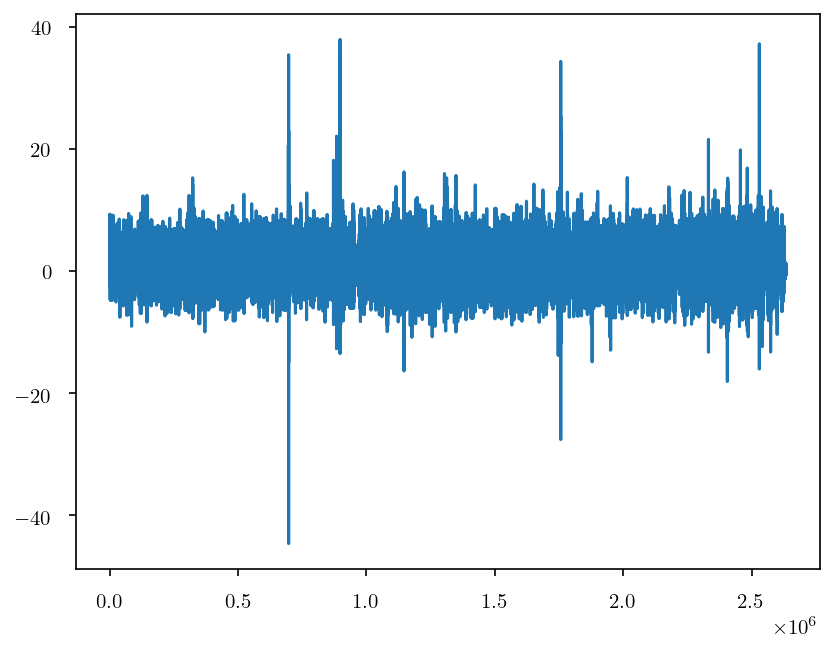

In [17]:
plt.plot(trades["r1"])

In [18]:
db = {'tt': trades.head(100000)}

### Calibrate and simulate the models

In [19]:

pb.calc_models(db, nfft='pad > 300', group=True, calibrate=True, split_by='sample')
# nfft options from fast to precise: 'crop', 'pad', 'demix'
# the addition '> 300' specifies to drop groups with fewer than 300 events
# feedback can be obtained using Python's logging module.

/Users/ana_bugaenko/workspace/priceprop/priceprop/batch.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt['sc'] = tt['sign'] * tt['change']
/Users/ana_bugaenko/workspace/priceprop/priceprop/batch.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt['sn'] = tt['sign'] * (~tt['change'])
/Users/ana_bugaenko/workspace/priceprop/priceprop/batch.py:414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [20]:
# A calibration dict 'cal' was added to db. 
# It includes one key for each of the sample groups 
# (based on the column "samples" created above)
print("Calibration completed for the following sample groups:")
print(db['cal'].keys())

Calibration completed for the following sample groups:
dict_keys([0, 1])


In [21]:
# the simulated time-series should now be included in the trades dataframe
db['tt'].head(20)

,r1,sign,change,date,sample,sc,sn,r_cim,r_tim1,r_tim2,r_hdim2,r_hdim2_x2
0,2.341556,-1,True,2017-01-03,1,-1,0,-1.0,-0.026407,0.001769,-0.024914,0.002331
1,2.341556,1,True,2017-01-03,1,1,0,1.0,0.045159,0.046854,0.090620,0.034784
2,0.000000,1,True,2017-01-03,1,1,0,1.0,0.036015,-0.004548,0.021282,0.005792
3,0.000000,1,False,2017-01-03,1,0,1,0.0,-0.009264,-0.029669,-0.000000,-0.000000
4,0.000000,1,False,2017-01-03,1,0,1,0.0,-0.024394,-0.002397,-0.000000,-0.000000
5,2.341556,1,True,2017-01-03,1,1,0,1.0,-0.031867,-0.060323,-0.070302,-0.048903
6,0.000000,1,False,2017-01-03,1,0,1,0.0,-0.043632,-0.054095,-0.000000,-0.000000
7,0.000000,1,False,2017-01-03,1,0,1,0.0,-0.047338,-0.028626,-0.000000,-0.000000
8,0.000000,1,False,2017-01-03,1,0,1,0.0,-0.049511,-0.031316,-0.000000,-0.000000
9,0.000000,1,False,2017-01-03,1,0,1,0.0,-0.061499,-0.048169,-0.000000,-0.000000


### Plot fitted model kernels

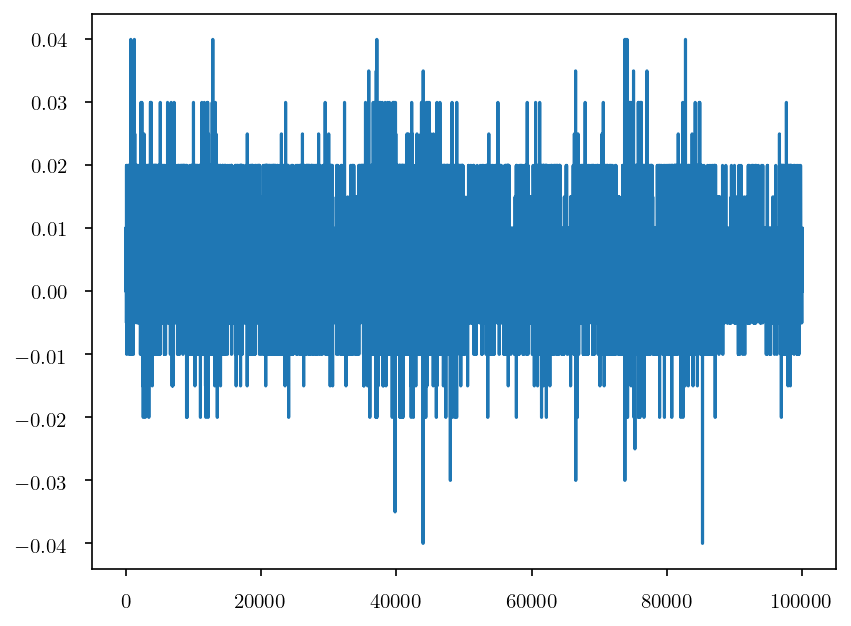

In [91]:
plt.plot(db['tt']["r1"])

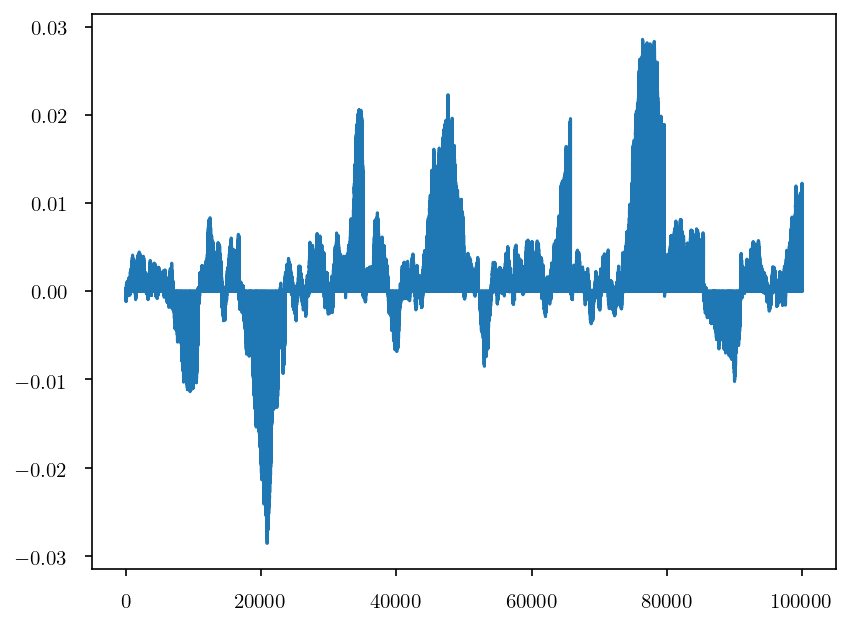

In [94]:
plt.plot(db['tt']["r_hdim2"])

In [ ]:
# simulate HDIM2 model as "ground truth"
# ---------------------------------------------

# maximum lag for propagator kernel
maxlag = 2**8
lags = np.arange(1,maxlag+1)

# time steps
t = np.arange(steps, dtype=int)

# some power law kernels
k_n = prop.k_pow(maxlag+1, prop.beta_from_gamma(gamma_s)) * 0.25
k_c = prop.k_pow(maxlag+1, prop.beta_from_gamma(gamma_s))
k_n[0] = 0
k_n[1] = .1

r = prop.hdim2(s, c, k_n, k_c)

In [93]:
db['cal'][sample]['kc']

array([-3.28153149e-05, -3.26516350e-04, -2.01885474e-04, ...,
        2.14545133e-04, -1.90761935e-04, -2.77644225e-04])

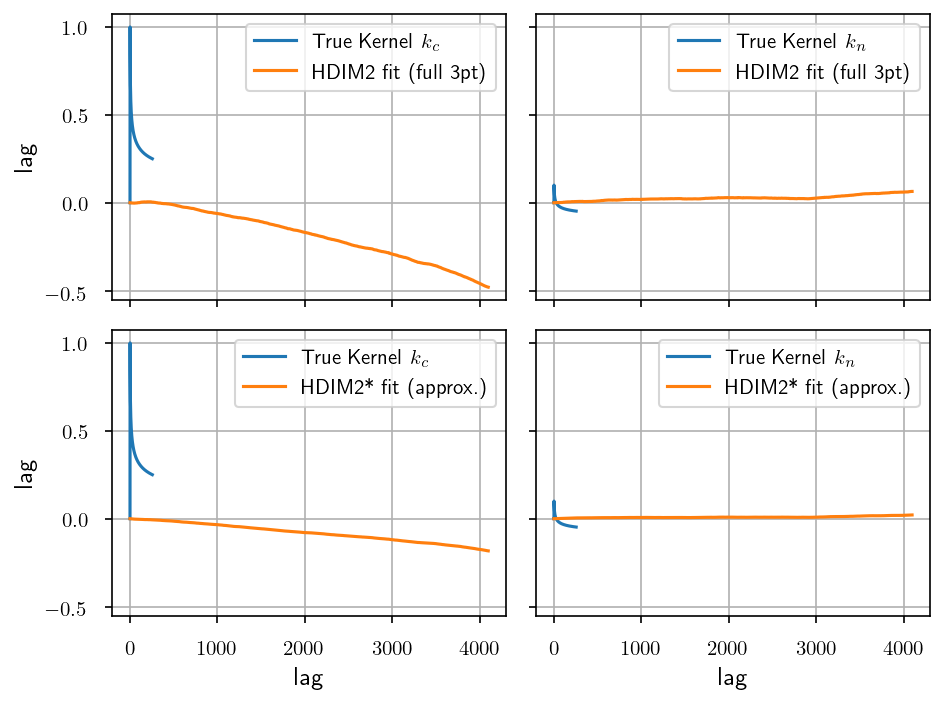

In [92]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

sample = 1 # choose of the keys listed above
fn = prop.integrate # show integrated kernels

ax[0,0].plot(fn(k_c), label='True Kernel $k_c$')
ax[0,0].plot(fn(db['cal'][sample]['kc']), label='HDIM2 fit (full 3pt)')
ax[0,0].legend()

ax[0,1].plot(fn(k_n), label='True Kernel $k_n$')
ax[0,1].plot(fn(db['cal'][sample]['kn']), label='HDIM2 fit (full 3pt)')
ax[0,1].legend()


ax[1,0].plot(fn(k_c), label='True Kernel $k_c$')
ax[1,0].plot(fn(db['cal'][sample]['kc_x2']), label='HDIM2* fit (approx.)')
ax[1,0].legend()

ax[1,1].plot(fn(k_n), label='True Kernel $k_n$')
ax[1,1].plot(fn(db['cal'][sample]['kn_x2']), label='HDIM2* fit (approx.)')
ax[1,1].legend()

# optimise
for a in ax[:,0]:
    a.set_ylabel('lag')
for a in ax[-1,:]:
    a.set_xlabel('lag')
for a in ax.flatten():
    a.grid(True)

plt.tight_layout()

### Plot the original "true" returns and those predicted from the fitted models

In [97]:
trades = db['tt']

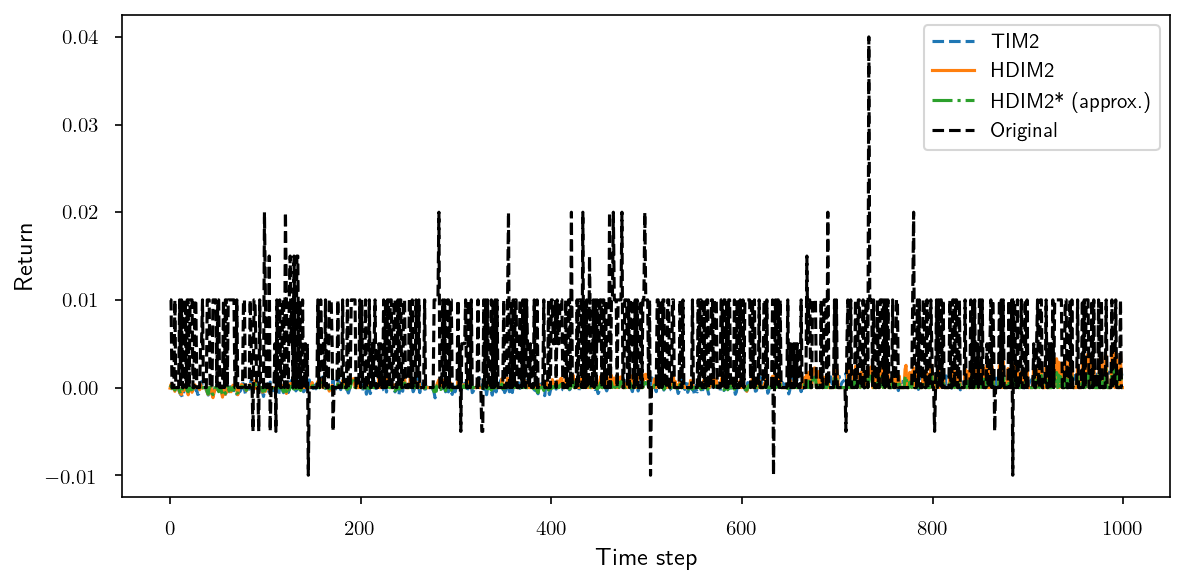

In [98]:
plt.figure(2, figsize=(8,4))
ax = plt.gca()

# choose a range between 0 and steps for the plot.
plot_start = 0
plot_end   = 1000
# plot the following predicted returns from these fitted models
# (un)comment lines to (de)select models
plot_models = [
    #'r_cim',
    #'r_tim1',
    'r_tim2',
    'r_hdim2',    # HDIM2 with full calibration
    'r_hdim2_x2' # HDIM2 with two-point approximation
]


# plot diverse models
rename_models = {
    i : i.upper().replace('R_','').replace('_X2','* (approx.)')
    for i in plot_models
}
styles = ['--','-','-.']
predicted_returns = (
    trades.iloc[plot_start:plot_end][plot_models]
    .rename(columns=rename_models)
)
predicted_returns.plot(style=styles,ax=ax)

# original returns
original_returns = trades.iloc[plot_start:plot_end][['r1']]
original_returns.columns = ['Original']
original_returns.plot(style='k--', ax=ax, )

# indicate date changes - there should be larger errors just at the beginning of a new day
plt.vlines(
    np.where(np.diff(trades['date'][plot_start:plot_end]))[0], 
    -2, 2, 
    linestyles=':', colors='#999999'
)

# format
ax.set_xlabel('Time step')
ax.set_ylabel('Return')
plt.tight_layout()

Zooming into the time series reveals that the HDIM2 is perfectly predicted using the correct calibration, but not as well using the approximate calibration or the TIM2.